<a href="https://colab.research.google.com/github/agroimpacts/adleo/blob/devel/assignments/assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1: Multi-layer perceptrons

**<font color='red'> 45/50 points on A 1</font>**

## Instructions

Please follow the [instructions](assignments-setup.qmd) for setting up, completing, and submitting your assignments.

## Assignment Overview

After completing this assignment you will learn:

- Mechanics of MLP and modern DNNs, their building blocks and how to implement our model using ```torch.nn``` package.
- How to develop an image classification pipeline using PyTorch. The process is broken down into the steps below:

How to follow the Steps to approach a supervised ML/DL problem:

1. Define the problem to be solved (e.g. task specification)
2. Collect (labeled) data, and prepare it for analysis including data type specific pre-processing plus data splits, chipping, normalization and augmentation.
3. Choose an algorithm class (architecture, training strategy, and cost function)
4. Choose an optimization and learning rate policy
5. Choose metrics to evaluate the model performance
6. Apply regularization techniques if needed (usually an iterative process)


## Assignment

Follow the instructions below to complete your coding assignment.

Run the code in the sections beginning with "Static" unchanged, unless otherwise indicated.

### Static code 1

In [1]:
# @title Mount drive and run imports
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
# @title Importing Necessary Packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [3]:
# @title Model save path

# Modify 'save_dir' to the path to your already downloaded MNIST dataset (from the main notebook).
save_dir = "/content/gdrive/MyDrive/adleo/data/assn1/"

### Static code 2
#### Transforms and loads (Steps 1.2-1.5)

In [4]:
# @title Necessary transforms - run unchanged
mnist_mean = 0.13066048920154572
mnist_std = 0.30810779333114624

train_transforms = transforms.Compose(
    [transforms.RandomRotation(5, fill=(0,)),
     transforms.RandomCrop(28, padding=2),
     transforms.ToTensor(),
     transforms.Normalize(mean=[mnist_mean], std=[mnist_std])]
     )

test_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[mnist_mean], std=[mnist_std])]
     )

In [5]:
# @title Load and split
train_data = datasets.MNIST(root=save_dir,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=save_dir,
                           train=False,
                           download=True,
                           transform=test_transforms)

train_ratio = 0.9

n_train_examples = int(len(train_data) * train_ratio)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,[n_train_examples,
                                                       n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [6]:
# @title Make iterable
# Don't change this cell
train_bsize=50
train_loader = data.DataLoader(train_data,
                               shuffle=True,
                               batch_size=train_bsize)

valid_loader = data.DataLoader(valid_data,
                               shuffle=False,
                               batch_size=train_bsize)

test_loader = data.DataLoader(test_data,
                              shuffle=False,
                              batch_size=train_bsize)

In [7]:
# @title Metrics and some other necessary functions
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc


def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = Variable(x).to(device)
        y = Variable(y).to(device)

        y_pred = model(x)

        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    # Disable automatic differentiation as we don't do optimization on eval.
    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = Variable(x).to(device)
            y = Variable(y).to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def plot_confusion_matrix(labels, pred_labels):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc


## Task 1: Adjust the model

Add the following five modifications to the model architecture:

1.  Use [leaky ReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html#leakyrelu) as activation function.
2.  Regularization is VERY important in practice and it is shown that [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#dropout) works very well with DNNs. Please add it.
3.  Batch normalization also acts as a regularizer, and usually results in a faster and better convergence. It is a common component of all modern neural networks.

  * **Hint 1:** You need to think where is the best place to add the BN layer before or after the non-linearity? Also, do you need to use [1D](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#batchnorm1d), [2D](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#batchnorm2d) or [3D](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm3d.html#batchnorm3d) implementation of BN based on that decision decide on the single required argument of the layer.

  * **Hint 2:** If you are using a BN layer you can set the bias for your ```nn.Linear()``` layer to ```False``` because the BN layer has a bias term included in it.

4. Its also good to have the option of using a $L_2$ regularization aka. [weight decay](https://d2l.ai/chapter_linear-regression/weight-decay.html) term. Please add it to your pipeline. Usually we choose a small term (e.g. ${1}^{-6}$).

  * **Hint:** In Pytorch, weight decay is implemented as part of the optimizer. For instance look at the arguments for [```torch.optim.SGD```](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#sgd).


5. There are two best coding rules that our code for ```MLP()``` violates. First several of the arguments to input layers are hard-coded (second argument to input layer, inputs and outputs, or nodes, to the hidden layer, and input to the output layer). Therefore, **your fifth required modification** is to revise the model so that it takes additional arguments that passes the information into the different layers, replacing the hard-coded values.

6. ***Optional but recommended:*** The model also fixes the number of hidden layers. What happens if you want to go deeper, and want more than one? This provides you with an optional modification you can make for extra credit, which is to design a model that can accept a flexible number of hidden layers and their feature sizes from the user.

  - **Hint:** ```hidden_dims``` should accept a list of integers where the length of the list decides on the number of hidden layers and each integer element represent the number of units in the layer. Your model should therefore have the exact same arguments as shown in the example below:

    ```
    model = MLP(in_dim, hidden_dims, out_dim, drop_rate)
    ```

**(30 points**, plus 2 extra for #6)  

**<font color='red'> 27/30 points on CA 1</font>**

In [8]:
# @title Modify your MLP as required
# Modify this cell
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dims=[250,100], drop_rate=0.5):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.dropout1 = nn.Dropout(drop_rate)  # Dropout layer after the first fully connected layer
        self.dropout2 = nn.Dropout(drop_rate)  # Dropout layer after the second fully connected layer
        self.layer3 = nn.Linear(hidden_dims[1], out_dim)

        optimizer = torch.optim.SGD(self.parameters(), lr=0.01, weight_decay=0.001)

        # Sequential block with LeakyReLU and dropout
        self.mlp_block = nn.Sequential(
            nn.Linear(in_dim, 250),
            nn.LeakyReLU(),
            nn.Dropout(drop_rate),
            nn.Linear(250, 100),
            nn.LeakyReLU(),
            nn.Dropout(drop_rate),
            nn.Linear(100, out_dim)
        )

    def forward(self, x):
        # Add your code here.
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)  # Apply dropout after the first layer
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)  # Apply dropout after the second layer
        y_pred = self.layer3(x)
        return y_pred

**TA comment**

You defined layers both individually `fc1, fc2, layer3` and inside mlp_block, but mlp_block is never used in `forward()`. That’s why your code runs without an error, but it's inefficient and redundant.

The optimizer is defined inside` __init__`, but it should be created outside the model in the training script. It is needed after each iteration, and since you didn’t use it in `forward()`, you didn’t encounter an error.

The problem statement required the sequence to be:
`nn.Linear` → `nn.BatchNorm1d` → `nn.LeakyReLu` → `nn.Dropout`
However, your implementation does not include `BatchNorm1d`, which does not meet the question's requirements.

Check below for the corrected code:

```
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dims=[250, 100], drop_rate=0.5):
        super(MLP, self).__init__()

        # Correcting the sequence and adding BatchNorm1d
        self.mlp_block = nn.Sequential(
            nn.Linear(in_dim, hidden_dims[0], bias=False),
            nn.LeakyReLU(),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.Dropout(drop_rate),

            nn.Linear(hidden_dims[0], hidden_dims[1], bias=False),
            nn.LeakyReLU(),
            nn.BatchNorm1d(hidden_dims[1]),
            nn.Dropout(drop_rate),

            nn.Linear(hidden_dims[1], out_dim)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        return self.mlp_block(x)

```

for the optional part, you could use this:

```
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dims, out_dim, dropout_rate):
        super(MLP, self).__init__()

        layers=[]
        layers.append(nn.Linear(in_dim, hidden_dims[0], bias=False))
        layers.append(nn.LeakyReLU())
        layers.append(nn.BatchNorm1d(hidden_dims[0]))
        
        for i in range(len(hidden_dims)-1):
          layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1], bias=False))
          layers.append(nn.BatchNorm1d(hidden_dims[i+1]))
          layers.append(nn.LeakyReLU())
          layers.append(nn.Dropout(dropout_rate))
        
        layers.append(nn.Linear(hidden_dims[-1], out_dim, bias=False))

        self.mlp_block = nn.Sequential(*layers)


    def forward(self, x):

        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        y_pred = self.mlp_block(x)

        return y_pred
```

If you are struggling to get it working, here is a commented out version of the example model that you can run and adapt.  You might want to use some of the other 3 examples that we suggested for structuring the model class

In [ ]:
# @title Examples
# class MLP(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(MLP, self).__init__()

#         self.input_fc = nn.Linear(input_dim, 250)
#         self.hidden_fc = nn.Linear(250, 100)
#         self.output_fc = nn.Linear(100, output_dim)

#     def forward(self, x):

#         # x is a batch of images with the shape: [batch size, height, width]
#         batch_size = x.shape[0]

#         # First, we have to convert the 2D tensor (H and W) in
#         # an Mnist image, into a 1D tensor so that it can be fed into the first
#         # Linear layer, and we do that using the view().
#         x = x.view(batch_size, -1)

#         # x is now have the shape: [batch size, (height * width)]

#         # we pass input through each layer and the activation function in order, finally
#         # returning the output to give us our prediction for that image.
#         h_1 = F.relu(self.input_fc(x))

#         # h_1 = [batch size, 250]
#         h_2 = F.relu(self.hidden_fc(h_1))

#         # h_2 = [batch size, 100]
#         y_pred = self.output_fc(h_2)

#         # y_pred = [batch size, output dim]

#         return y_pred

In [9]:
# @title Define the parameters needed to run the model
in_dim = 28 * 28
initial_lr = 0.001    # Hyper-parameter that you can change for optional part
num_epochs = 10    # Hyper-parameter that you can change for optional part
train_bsize = 54   # training batch size--can change for optional part

# new variables
hidden_dims = 0# provide integer or list of integers,
              # depending on the coding choices you make
out_dim = 10
drop_rate = 0  # choose a number in the range [0,1] for your dropout
# Look on the web and experiment yourself to find a good rate


**TA Comment**

If you are defining hidden_dims again for a 2-hidden-layer MLP, you should explicitly write your list here (i.e., [250, 100]). Otherwise, you shouldn't redefine it, as it will be replaced with 0 in this implementation, causing an error. The reason you didn't see the error is that you didn't call the last two arguments of your model, so the default values were used when you initialized your MLP.

```
model = MLP(in_dim, out_dim)
```



## Task 2: Show your work

Having updated the model with these modifications, your job is to show that the model works.  Re-run Steps 4-6 in the practical to train the model, show its loss curves, evaluates its performance, and save its output.

**(10 points for completing all below)**

**<font color='red'> 18/20 points on CA 2</font>**

In [10]:
# @title Run and print the model
# Don't change this cell
#model = MLP(in_dim, hidden_dims, out_dim, drop_rate)
model = MLP(in_dim, out_dim)
print(model)

MLP(
  (fc1): Linear(in_features=784, out_features=250, bias=True)
  (fc2): Linear(in_features=250, out_features=100, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (layer3): Linear(in_features=100, out_features=10, bias=True)
  (mlp_block): Sequential(
    (0): Linear(in_features=784, out_features=250, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=250, out_features=100, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
)


In [11]:
# @title Show the number of parameters in the model
# Don't change this cell
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 444,720 trainable parameters


In [12]:
# @title Optimizer, loss criterion, and GPU/CPU switch
optimizer = optim.Adam(model.parameters(), lr=initial_lr)
criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

**TA Comment**

Here is where you needed to add weight decay:

```
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.01)
```


In [ ]:
# @title Train the model
best_val_loss = float('inf')
train_loss_per_epoch = []
val_loss_per_epoch = []
epoch_counter = []

for epoch in trange(num_epochs):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, valid_loader, criterion, device)

    #simple implementation of early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_mlp_tutorial.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')

    epoch_counter.append(epoch)
    train_loss_per_epoch.append(train_loss)
    val_loss_per_epoch.append(val_loss)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1080 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 25s
	Train Loss: 0.765 | Train Acc: 75.50%
	 Val. Loss: 0.209 |  Val. Acc: 94.43%


Training:   0%|          | 0/1080 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 24s
	Train Loss: 0.450 | Train Acc: 86.66%
	 Val. Loss: 0.141 |  Val. Acc: 96.12%


Training:   0%|          | 0/1080 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 24s
	Train Loss: 0.389 | Train Acc: 88.50%
	 Val. Loss: 0.135 |  Val. Acc: 96.10%


Training:   0%|          | 0/1080 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 26s
	Train Loss: 0.352 | Train Acc: 89.63%
	 Val. Loss: 0.128 |  Val. Acc: 96.10%


Training:   0%|          | 0/1080 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 25s
	Train Loss: 0.332 | Train Acc: 90.40%
	 Val. Loss: 0.107 |  Val. Acc: 96.65%


Training:   0%|          | 0/1080 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 25s
	Train Loss: 0.319 | Train Acc: 90.69%
	 Val. Loss: 0.103 |  Val. Acc: 96.97%


Training:   0%|          | 0/1080 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 25s
	Train Loss: 0.309 | Train Acc: 90.97%
	 Val. Loss: 0.101 |  Val. Acc: 96.95%


Training:   0%|          | 0/1080 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 25s
	Train Loss: 0.301 | Train Acc: 91.37%
	 Val. Loss: 0.109 |  Val. Acc: 97.03%


Training:   0%|          | 0/1080 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 25s
	Train Loss: 0.293 | Train Acc: 91.43%
	 Val. Loss: 0.092 |  Val. Acc: 97.33%


Training:   0%|          | 0/1080 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 25s
	Train Loss: 0.292 | Train Acc: 91.59%
	 Val. Loss: 0.094 |  Val. Acc: 97.15%


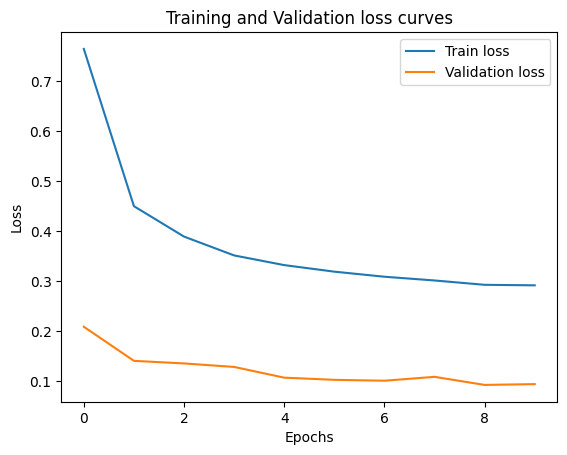

In [ ]:
# @title Plot the results
plt.plot(epoch_counter, train_loss_per_epoch, label="Train loss")
plt.plot(epoch_counter, val_loss_per_epoch, label="Validation loss")
plt.title("Training and Validation loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

Evaluate the performance

In [ ]:
# @title Evaluate the performance
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Test Loss: 0.085 | Test Acc: 97.37%


Show the matrix

**TA Comment**

to bve able to show the matrix you should run and call the `get_predictions_ function (see MLPs practical). This way you're defining the `images`, `labels`, `probs` variables, that requires to run the next part:



```
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs
```


```
images, labels, probs = get_predictions(model, test_loader, device)
pred_labels = torch.argmax(probs, 1)
```

In [ ]:
# @title Show the matrix
plot_confusion_matrix(labels, pred_labels)

NameError: name 'labels' is not defined

## Optional Task 3

Use the model above and the parameters for batch size, learning rate, and dropout to evaluate model performance. Repeat using the code above from Task 2: Show your work. Provide the outputs (loss curves, performance metrics), from the best and worst results in the cells below.

**Practical tip:**
First tune the number of layers and number of computational units in each layer.
Check the models behavior and then tune the regularization parameter.

**(10 extra points)**

### Best result

### Worst result

In [ ]:
##Use of Gen AI for debugging: I used a few different AI sources as aids in this assignment. I tried my best to not simply ask programs to spit out correct code. Between Chat GPT, Copilot, and Gemini, I found Gemini to be the most helpful- particularly using the built in feature in Colab. For my use of copilot I found it a bit difficult to export the link to a conversation so I have pasted the conversations I had with it at the bottom.


##Gemini Conversation:
# Please explain the error:

# TypeError: MLP.__init__() missing 1 required positional argument: 'out_dim'
# Hypothesis
# The error message TypeError: MLP.__init__() missing 1 required positional argument: 'out_dim' indicates that the __init__ method of the MLP class is being called with fewer arguments than it expects.

# Specifically, it's expecting an argument named out_dim, which represents the output dimension of the model (likely the number of classes in your classification problem), but it's not being provided. This mismatch between the expected and actual number of arguments passed to the constructor is causing the TypeError.

# This error arose in cell 19, where you attempted to create an instance of your MLP class. You called model = MLP(in_dim, out_dim) while your definition of MLP in cell 0 actually takes input_dim and output_dim as arguments.

# Suggested Changes

# # @title Run and print the model
# # Don't change this cell
# #model = MLP(in_dim, hidden_dims, out_dim, drop_rate)
# model = MLP(input_dim=in_dim, output_dim=out_dim) # Modified line
# print(model)
# Use code with caution
# Explanation of Changes

# Argument Names: The original call MLP(in_dim, out_dim) was using variable names in_dim and out_dim, while the __init__ method of the MLP class (defined in cell 0) expects input_dim and output_dim.
# Corrected Call: We modified the line to model = MLP(input_dim=in_dim, output_dim=out_dim). This change makes sure the correct argument names are used when creating the MLP instance, matching the definition in the __init__ method. By explicitly naming the arguments, we avoid confusion and ensure the values are assigned to the correct parameters.
# Sources
# Rate this answer
# i need to not change the run and print cell- per assignment instructions. please help me resolve this issue by improving the init function

# Okay, understood. You want to keep the Run and print the model cell unchanged and modify the __init__ function of the MLP class to resolve the issue.

# Hypothesis
# The problem arises from a mismatch between the __init__ method definition of the MLP class and how it's called. In the Run and print the model cell, model = MLP(in_dim, out_dim) is used to instantiate the class, suggesting that the __init__ method should take two arguments. However, your current __init__ method likely has a different signature, causing the TypeError.

# Suggested Changes

# # @title Examples
# class MLP(nn.Module):
#     def __init__(self, input_dim, output_dim): # Modified line
#         super(MLP, self).__init__()

#         self.input_fc = nn.Linear(input_dim, 250)
#         self.hidden_fc = nn.Linear(250, 100)
#         self.output_fc = nn.Linear(100, output_dim)

#     def forward(self, x):

#         # ... (rest of the forward method remains the same) ...
# Use code with caution
# Explanation of Changes:

# Modified __init__: We've changed the __init__ method signature to def __init__(self, input_dim, output_dim):, replacing the likely different argument names with input_dim and output_dim to match the call in the Run and print the model cell.
# Preserving Forward Method: The rest of the forward method in your MLP class should remain unchanged.
# How it Works:

# Now, when you execute model = MLP(in_dim, out_dim) in the Run and print the model cell, the values of in_dim and out_dim will be correctly passed to the input_dim and output_dim parameters of the __init__ method, avoiding the TypeError.
# By adjusting the __init__ method to expect the correct number and names of arguments, you've established consistency with how it's called, ensuring your code runs without the TypeError.

# Sources
# Rate this answer
# this is my init function block; please explain what I should change within it to rectify my issue:

# class MLP(nn.Module): def init(self, in_dim, hidden_dims, out_dim, drop_rate=0.5): super(MLP, self).init() self.fc1 = nn.Linear(in_dim, hidden_dims[0]) self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1]) self.dropout1 = nn.Dropout(drop_rate) # Dropout layer after the first fully connected layer self.dropout2 = nn.Dropout(drop_rate) # Dropout layer after the second fully connected layer self.layer3 = nn.Linear(hidden_dims[1], out_dim)

#     optimizer = torch.optim.SGD(self.parameters(), lr=0.01, weight_decay=0.001)

#     # Sequential block with LeakyReLU and dropout
#     self.mlp_block = nn.Sequential(
#         nn.Linear(in_dim, 250),
#         nn.LeakyReLU(),
#         nn.Dropout(drop_rate),
#         nn.Linear(250, 100),
#         nn.LeakyReLU(),
#         nn.Dropout(drop_rate),
#         nn.Linear(100, out_dim)
#     )

# def forward(self, x):
#     # Add your code here.
#     x = torch.relu(self.fc1(x))
#     x = self.dropout1(x)  # Apply dropout after the first layer
#     x = torch.relu(self.fc2(x))
#     x = self.dropout2(x)  # Apply dropout after the second layer
#     y_pred = self.layer3(x)
#     return y_pred
# Okay, let's analyze your __init__ function and determine the necessary changes.

# Problem:

# The issue stems from the fact that your __init__ method is defined to take four arguments: in_dim, hidden_dims, out_dim, and drop_rate. However, in your Run and print the model cell, you are calling it with only two arguments: in_dim and out_dim. This mismatch causes the TypeError.

# Solution:

# To fix this without changing the Run and print the model cell, you need to make the hidden_dims and drop_rate arguments optional within your __init__ method. This way, the method can handle being called with just in_dim and out_dim.

# Modified __init__ Function:


# class MLP(nn.Module):
#     def __init__(self, in_dim, out_dim, hidden_dims=[250, 100], drop_rate=0.5): # Modified line
#         super(MLP, self).__init__()
#         self.fc1 = nn.Linear(in_dim, hidden_dims[0])
#         self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
#         self.dropout1 = nn.Dropout(drop_rate)
#         self.dropout2 = nn.Dropout(drop_rate)
#         self.layer3 = nn.Linear(hidden_dims[1], out_dim)

#         optimizer = torch.optim.SGD(self.parameters(), lr=0.01, weight_decay=0.001)

#         # Sequential block with LeakyReLU and dropout
#         self.mlp_block = nn.Sequential(
#             nn.Linear(in_dim, 250),
#             nn.LeakyReLU(),
#             nn.Dropout(drop_rate),
#             nn.Linear(250, 100),
#             nn.LeakyReLU(),
#             nn.Dropout(drop_rate),
#             nn.Linear(100, out_dim)
#         )

#     # ... (rest of the class remains the same) ...
# Use code with caution
# Explanation of Changes:

# Optional Arguments: We've modified the __init__ method signature to:

# def __init__(self, in_dim, out_dim, hidden_dims=[250, 100], drop_rate=0.5):
# Use code with caution
# By providing default values for hidden_dims and drop_rate, we make them optional. Now, if the method is called with only two arguments (in_dim and out_dim), it will use these default values.

# How it Works:

# With this change, your Run and print the model cell (model = MLP(in_dim, out_dim)) will work without errors. It will use the default values for hidden_dims ([250, 100]) and drop_rate (0.5).
# If you want to specify different values for hidden_dims or drop_rate, you can still call the __init__ method with all four arguments, like this:

# model = MLP(in_dim, hidden_dims=[128, 64], out_dim, drop_rate=0.2)
# Use code with caution
# By making these arguments optional, you've made your MLP class more flexible and compatible with the existing code in the Run and print the model cell.

# # Please explain the error:

# RuntimeError: mat1 and mat2 shapes cannot be multiplied (1400x28 and 784x250)
# Hypothesis
# The error message "RuntimeError: mat1 and mat2 shapes cannot be multiplied (1400x28 and 784x250)" indicates a matrix multiplication issue within the forward method of your MLP class. This is most likely due to incorrect input dimensions during the forward pass, particularly in the first layer (self.fc1).

# Let's break this down:

# The traceback shows the error originating in this line: x = torch.relu(self.fc1(x)).
# The error message says the shapes of the matrices being multiplied are incompatible: (1400x28) and (784x250).
# The first matrix (1400x28) is the input x to the self.fc1 layer.
# The second matrix (784x250) represents the weights of self.fc1, which was initialized to expect an input of size 784 (28x28, the flattened image size).
# This mismatch arises because the input x has a shape of (1400x28) which doesn't match the expected input size of 784 for the first linear layer.
# In simpler terms, your model expects an input of size 784 (which you defined as in_dim), but it's receiving an input with a shape of (1400x28). This mismatch in dimensions leads to the matrix multiplication error.

# Suggested Changes

# class MLP(nn.Module):
#     def __init__(self, in_dim, out_dim, hidden_dims=[250, 100], drop_rate=0.5):
#         super(MLP, self).__init__()
#         self.fc1 = nn.Linear(in_dim, hidden_dims[0])  # First fully connected layer
#         self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])  # Second fully connected layer
#         self.dropout1 = nn.Dropout(drop_rate)  # Dropout after the first layer
#         self.dropout2 = nn.Dropout(drop_rate)  # Dropout after the second layer
#         self.layer3 = nn.Linear(hidden_dims[1], out_dim)  # Output layer


#     def forward(self, x):
#         # Reshape the input to (batch_size, in_dim) before passing it to the first layer
#         x = x.view(x.size(0), -1)

#         # Pass input through each layer with activation and dropout
#         x = torch.relu(self.fc1(x))
#         x = self.dropout1(x)
#         x = torch.relu(self.fc2(x))
#         x = self.dropout2(x)
#         y_pred = self.layer3(x)
#         return y_pred
# Use code with caution
# Explanation of changes:

# Reshape the input: The key change is to reshape the input x within the forward method. The line x = x.view(x.size(0), -1) flattens the input tensor x to have a shape of (batch_size, in_dim), ensuring that it matches the expected input size of the first linear layer (self.fc1). This addresses the core issue of mismatched dimensions during matrix multiplication.
# By incorporating this change, the input data will be correctly formatted for the model's layers, resolving the "RuntimeError: mat1 and mat2 shapes cannot be multiplied" error and allowing your MLP to train correctly.

# Sources
# Rate this answer
# could you please reprint the specific line i should change

# Okay, here is the specific line you should add to your forward method in the MLP class to resolve the error:


# x = x.view(x.size(0), -1)
# Use code with caution
# You should insert this line at the beginning of the forward method, before passing the input x to the first layer (self.fc1). This line reshapes the input tensor x to have the correct dimensions expected by the model, ensuring that matrix multiplication can be performed without errors.

# Here's how your modified forward method should look:


# def forward(self, x):
#         x = x.view(x.size(0), -1) # Add this line to reshape the input
#         x = torch.relu(self.fc1(x))
#         x = self.dropout1(x)
#         x = torch.relu(self.fc2(x))
#         x = self.dropout2(x)
#         y_pred = self.layer3(x)
#         return y_pred